# Interactive Sneddon Tool 

## Plot the distribution of stress around a fracture



### Theory & Description

2-D stress shadow model
The fundamental line crack model discussed in Sneddon (1946) assumes plane strain in the height direction. This model calculates the incremental stress induced in the plane of the propagating crack with a uniform net pressure opening the crack. Using this model, the volumetric stress change induced by a fracture can be calculated at any location in the plane of the fracture. The coordinate system used is described in Fig. 1  

#### Coordinate System Used
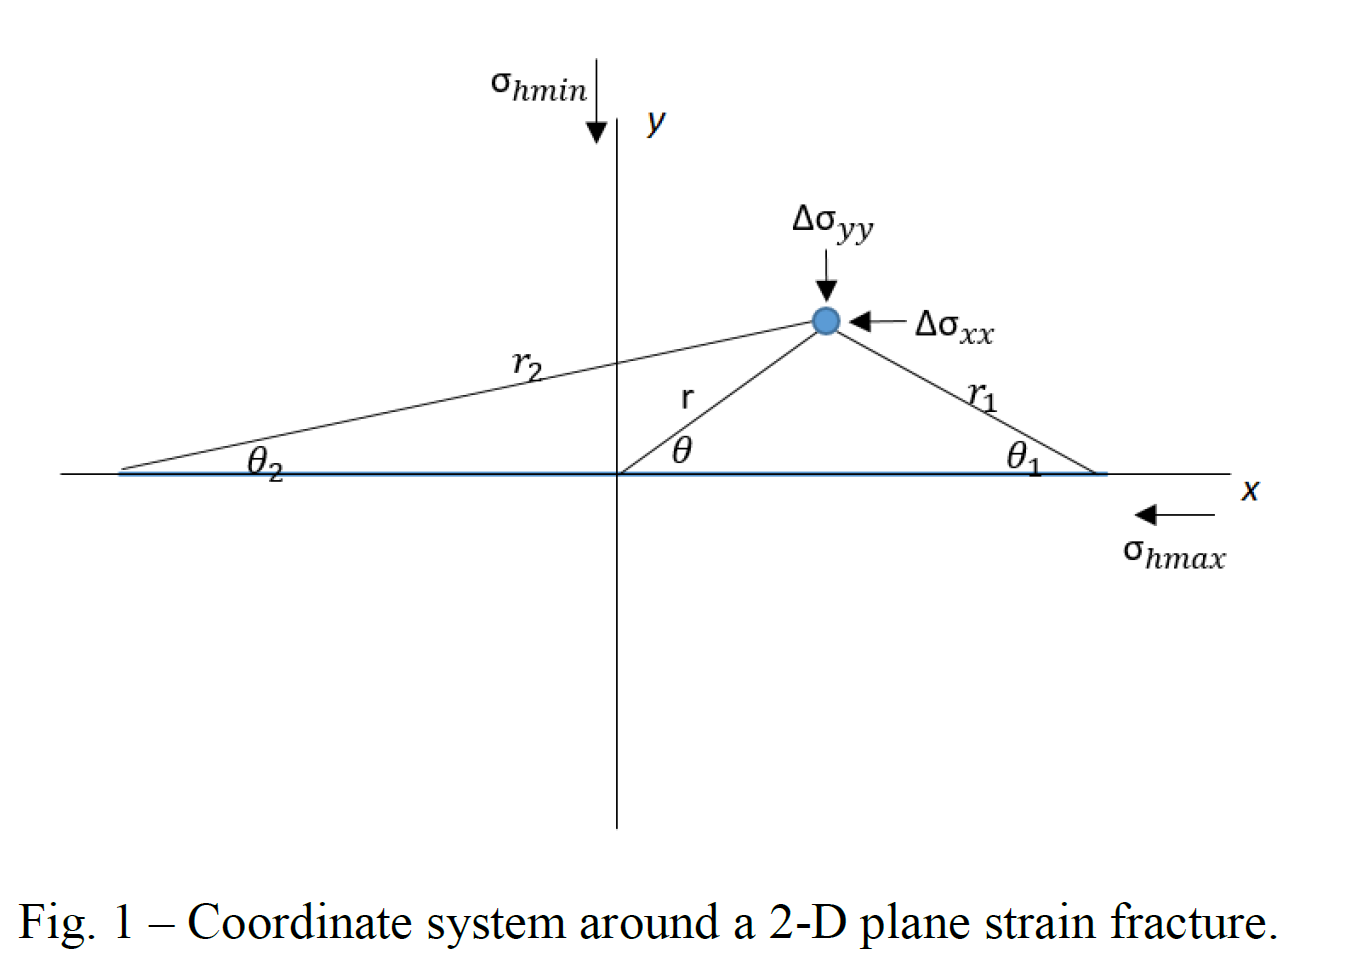

#### INSTRUCTIONS:
Run Each block in the notebook in sequence to initiate functionality of widgets
use the widget sliders to alter various fracture parameters (P_net,frac_half_length, Color_range,Frac_AZI, Stage_to_gauge)

Notebook outline
1.  Markdown block  (header info, general directions , & references)
2.  Functions for Plotting (Load functions to compute stress shadow)
3.  Widget Tool & Comparison Plot (loads widgets and plots 2D sneddon solution)

#### Reference Sneddon (1946) 

Sneddon, I. N. “The Distribution of Stress in the Neighborhood of a Crack in an Elastic Solid”. Proc., Royal Soc. Of London (Oct. – Dec., 1946) Series A, 187, 229 – 260


### Brendan Elliott,  2022

#### https://github.com/brendan07elliott
#### Brendan.elliott@utexas.edu

In [6]:
#______________INTERACTIVE SNEDDON TOOL________________
#this tool will show the pressure and stress around a fracture according to the Sneddon Solution
#REFERENCE:  Sneddon, I. N. “The Distribution of Stress in the Neighborhood of a Crack in an Elastic Solid”. Proc., Royal Soc. Of London (Oct. – Dec., 1946) Series A, 187, 229 – 260

#widgets control the fracture input parameters and a mapview of resulting stress is displayed

#run this section to load the libraries and functions to calculate stresses
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
from ipywidgets import interact         #for interactive features
import ipywidgets as widgets
from math import radians

def sneddon_2d_decay(x, y, xf):
    """
    Calculating the decay of the stress shadow. This returns the normalized value of volumetric stress as a function of
    x and y where the fracture location is between (-xf, 0) and (xf, 0)
    :param x: x coordinate in the reservoir
    :param y: y coordinate in the reservoir
    :param xf: fracture half length
    :return: decay values
    """

    # Calculating r
    r = sneddon_2d_r(x, y, 0.0, 0.0)
    r1 = sneddon_2d_r(x, y, xf, 0.0)
    r2 = sneddon_2d_r(x, y, -xf, 0.0)

    # Calculating theta
    theta = sneddon_2d_theta(x, y, 0.0, 0.0)
    theta1 = sneddon_2d_theta(x, y, xf, 0.0)
    theta2 = sneddon_2d_theta(x, y, -xf, 0.0)

    return r / np.sqrt(r1 * r2) * np.cos(theta - (theta1 + theta2) / 2.0) - 1.0


def sneddon_2d(x, y, xf, pnet):
    """
    Calculating the stress shadow. This returns the volumetric stress as a function of x and y where the fracture
    location is between (-xf, 0) and (xf, 0)
    :param x: x coordinate in the reservoir
    :param y: y coordinate in the reservoir
    :param xf: fracture half length
    :param pnet: constant net pressure in the fracture
    :return: stress shadow compression positive
    """
    return -pnet * sneddon_2d_decay(x, y, xf)

def sneddon_2d_r(x, y, x0, y0):
    """
    Convert x and y coordinate into r
    :param x: x coordinate
    :param y: y coordinate
    :param x0: origin x coordinate
    :param y0: origin y coordinate
    :return: r
    """
    return np.sqrt((x - x0) ** 2 + (y - y0) ** 2)


def sneddon_2d_theta(X, Y, x0, y0):
    """
    Convert x and y coordinate into theta
    :param x: x coordinate
    :param y: y coordinate
    :param x0: origin x coordinate
    :param y0: origin y coordinate
    :return: theta
    """
    return np.arctan2((Y - y0), (X - x0))

def plot_image(x, y, z, minv=-10.0, maxv=10.0):
    fig, ax = plt.subplots()
    im = plt.imshow(z, cmap=cm.jet, vmin=minv, vmax=maxv, extent=[x.min(), x.max(), y.min(), y.max()])
    # im = plt.imshow(z, cmap=cm.RdBu, extent=[x.min(), x.max(), y.min(), y.max()])
    im.set_interpolation('bilinear')
    fig.colorbar(im)
    ax.set_xlabel('X coordinate (m)', {'fontname': 'Times New Roman'})
    ax.set_ylabel('Y coordinate (m)', {'fontname': 'Times New Roman'})
    ax.set_xlim([x.min(), x.max()])
    ax.set_ylim([y.min(), y.max()])
    fig.set_size_inches(15, 10)
    ax.grid(False)
    return ax



In [7]:
#________Interactive Sneddon Tool_____________
#  run this section to display widgets for the Sneddon Plot
np.seterr(divide='ignore', invalid='ignore')  #gets rid of error when divide by zero

%matplotlib inline
@interact(P_net=(0,1000,5),frac_half_length=(1,2000,50),Frac_AZI=(0,90,1), Stage_to_gauge=(0,1000,1)) # Widget variables 
def plotter(P_net=210, frac_half_length=200, Frac_AZI=90, Stage_to_gauge=200):
    x_size=2*frac_half_length
    y_size=2*frac_half_length
    Color_range=P_net

    x = np.arange(-x_size, x_size+1, 1)
    y = np.arange(-y_size, y_size+1, 1)
    x, y = np.meshgrid(x, y)

    # Values
    frac_half_length = frac_half_length  #m
 
    p_net = P_net*6894.76  #pa
    minv = - Color_range #/ 1e6
    maxv =  Color_range #/ 1e6
    z = sneddon_2d(x, y, frac_half_length, p_net) / 6894.76
    x2 = x[:, x_size]
    y2 = y[:,y_size]
    z2 = z[:,x_size]
    
    #________________________________________________________________
    #MEASURED FIELD GAUGE DATA
    #field Measured distances from monitor
    y3 = [240, 390, 540, 690, 840, 990, 1140.25]  # mid point measured in ft
    y3=np.array(y3)*.3048 #convert to m
    #field Measured Pressure Response
    z3 = [120 , 90 , 60 , 50 , 40 , 30 , 23] #measured in psi
    z3=np.array(z3)*6894.76  #convert to Pa
   
    #define a wellbore
    well_length=5000*.3048  #ft to m
    STG= Stage_to_gauge
    x1_pos=-(well_length-STG)*np.sin(radians(90-Frac_AZI)) 
    y1_pos=-(well_length-STG)*np.cos(radians(90-Frac_AZI)) 
    x2_pos= STG*np.tan(radians(90-Frac_AZI))
    y2_pos=STG
    gauge_perp2=(x2_pos**2+y2_pos**2)**.5

    #Plot Sneddon
    x_vals = np.arange(1,1500,1)
    x2_vals = np.arange(0,1500,1)  #units of ft    
    
    
    plot_image(x, y, z, minv, maxv)
    plt.plot([x1_pos, x2_pos], [y1_pos, y2_pos], 'k-', color = 'k',linewidth=3.0)
    plt.scatter(x2_pos,y2_pos,label='Gauge  '+str(round(z[y_size-int(y2_pos),x_size],2))+' psi')
    plt.legend()
    plt.show()
    
    #Plot Comparison Sacatter chart
    plt.figure(figsize=(15,10))
    plt.scatter(y2/.3048,z2,s=15,label='Sneddon Model Prediction')
    plt.scatter(y3/.3048,z3/6894,s=150,label='Measured Field Gauge Data')     
    plt.scatter(0,210,s=100,label='DFIT Measured')
    plt.xlabel('Distance from Fracture Face (ft)', {'fontname': 'Times New Roman'}, size=24)
    plt.ylabel('Pressure Response (PSI)', {'fontname': 'Times New Roman'},size=24)
    plt.legend(prop={'size': 24})#loc='upper left')
    plt.ylim(ymin = 0, ymax = 250)
    plt.xlim(xmin = -100, xmax=2000)
    plt.grid()
    plt.title('Gauge Data vs Sneddon Model')
    plt.show()
    


interactive(children=(IntSlider(value=210, description='P_net', max=1000, step=5), IntSlider(value=200, descri…